In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from datetime import datetime, timedelta
%matplotlib inline
%config InlineBackend.figure_format='retina'
import rasterio
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.interpolate import griddata
plt.rcParams.update({'font.size': 14})

In [2]:
DEM  = rasterio.open('../data/characterization_data/LiDAR/DEM_RTK.tif').read(1)
DEM[DEM<0]=0

# 1. Weather station data

## Precipitation

In [3]:
Met_station = pd.read_csv('../data/characterization_data/Weather/preprocessing/SLT_OBJ2_MetStation_2020_2022.csv')
Met_station['DateTime.MST'] = [datetime.strptime(time,'20%y-%m-%d %H:%M:%S') for time in Met_station['DateTime.MST']]
Met_station['date'] = [time.date() for time in Met_station['DateTime.MST']]

In [4]:
Met_sum_daily = pd.DataFrame(Met_station.groupby(['date'])['Precip.mm'].sum())

In [5]:
start_date=pd.Timestamp('2020-10-01 00:00:00')
end_date=pd.Timestamp('2022-09-30 00:00:00')

In [6]:
# Create continuous date range
continuous_index = pd.date_range(start=Met_sum_daily.index.min(), end=Met_sum_daily.index.max())

# Reindex Met_sum_daily DataFrame with continuous date range
Met_sum_daily = Met_sum_daily.reindex(continuous_index)

# Select only the 'Precip.mm' column
Met_sum_daily = pd.DataFrame({'Precip.mm': Met_sum_daily['Precip.mm']})

# Optionally, fill missing values with 0
Met_sum_daily.fillna(0, inplace=True)

In [7]:
month_avg = Met_sum_daily['Precip.mm'].rolling(window=10).mean()

In [8]:
plt.figure(figsize = [7,2],tight_layout=True)
alpha = [0.3,0.7,1]
time_interval_snowmelt = ['2020-07-01','2020-08-02'],['2021-04-12','2021-07-01'],['2022-04-20','2022-07-09']
time_interval_dry = ['2021-09-12','2021-09-27'],['2021-12-06','2021-12-31'],['2022-07-16','2022-10-01']
time_interval_baseflow = ['2021-08-10','2021-08-20'],

# Convert string dates to datetime objects
time_interval_snowmelt = [[datetime.strptime(date, '%Y-%m-%d') for date in interval] for interval in time_interval_snowmelt]
time_interval_dry = [[datetime.strptime(date, '%Y-%m-%d') for date in interval] for interval in time_interval_dry]
time_interval_baseflow = [[datetime.strptime(date, '%Y-%m-%d') for date in interval] for interval in time_interval_baseflow]


<Figure size 700x200 with 0 Axes>

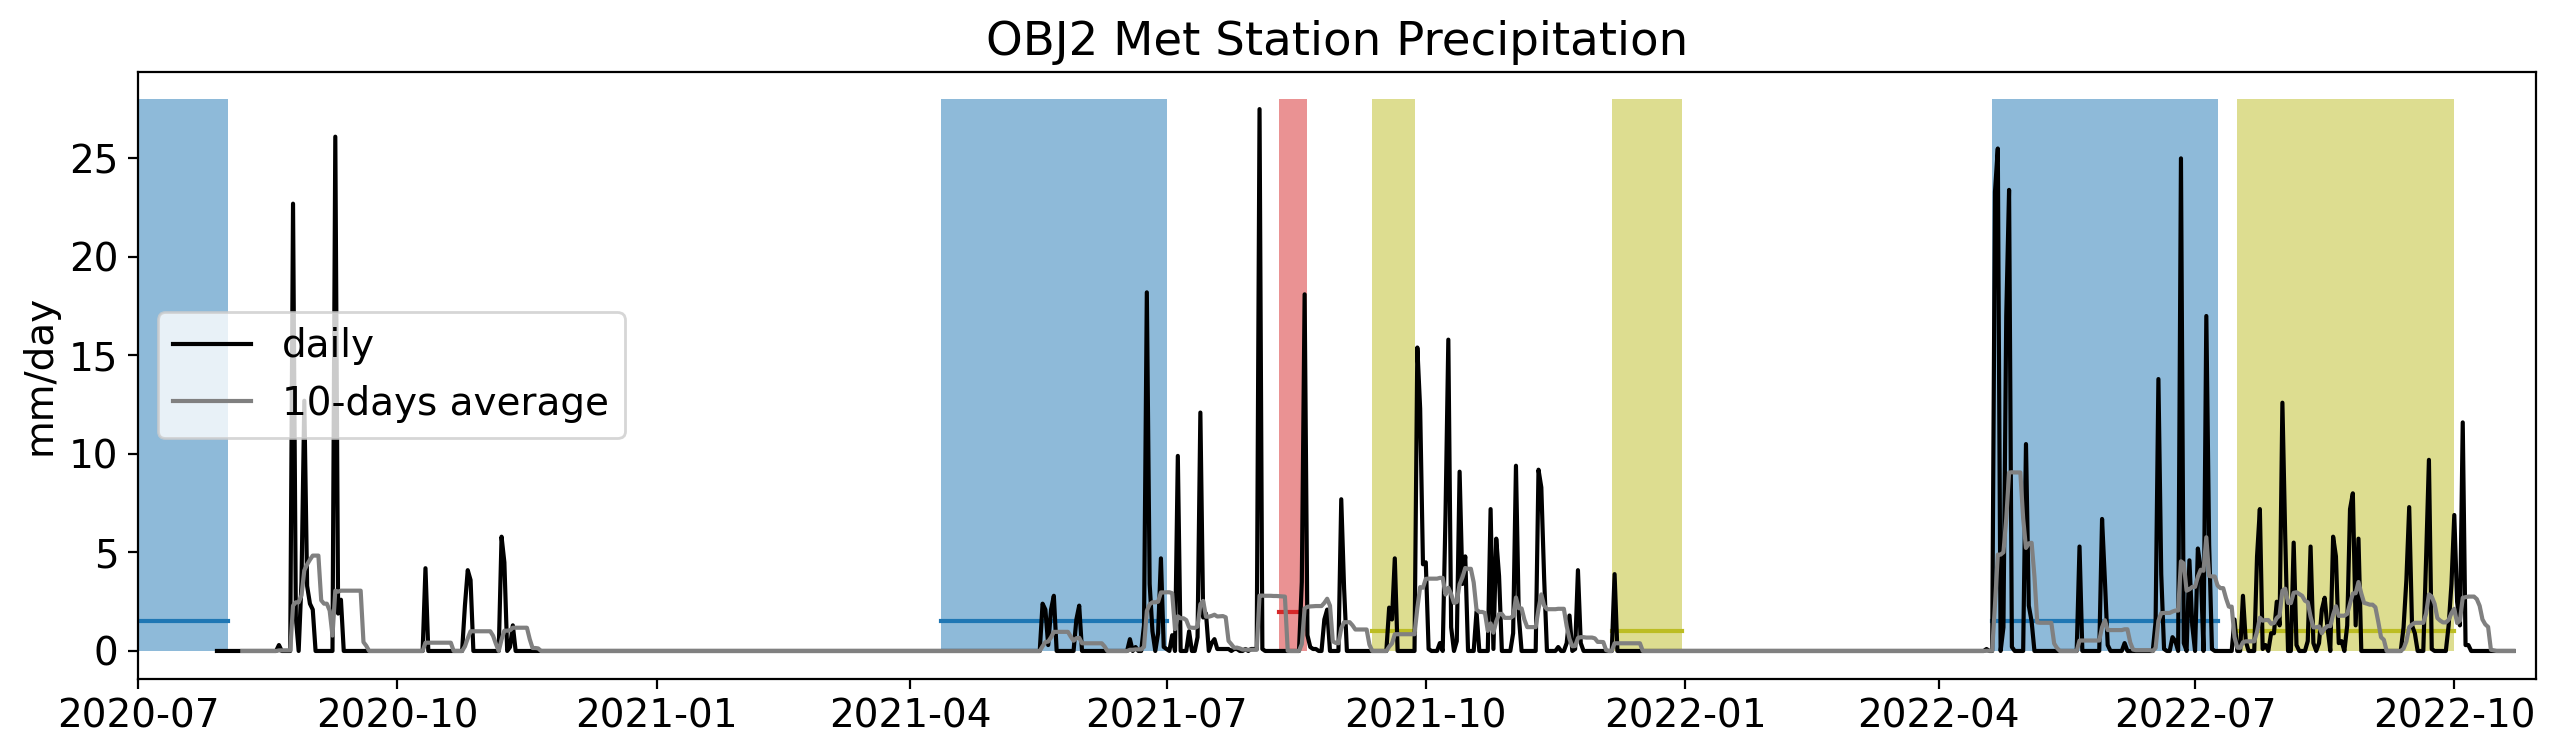

In [9]:
start_date_ET=pd.Timestamp('2020-07-01 00:00:00')
end_date_ET=pd.Timestamp('2022-10-30 00:00:00')

plt.figure(figsize = [13,4],tight_layout=True)
for interval in time_interval_snowmelt:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [28, 28], alpha=0.5,facecolor='C0')
    plt.plot(interval, [1.5, 1.5], c = 'C0')

for interval in time_interval_dry:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [28, 28], alpha=0.5,facecolor='C8')
    plt.plot(interval, [1, 1], c = 'C8')
    
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [28, 28], alpha=0.5,facecolor='C3')
    plt.plot(interval, [2, 2], c = 'C3')
plt.plot(Met_sum_daily.reindex(continuous_index)['Precip.mm'],label = 'daily',c = 'black')
plt.plot(month_avg,label = '10-days average',c = 'grey')
plt.ylabel('mm/day')
plt.xlim(start_date_ET,end_date_ET)
#plt.ylim(-0.01,10)
plt.title('OBJ2 Met Station Precipitation')
plt.legend()

## ET

In [11]:
ET = pd.read_csv('../data/characterization_data/Weather/preprocessing/SLT_OBJ2_PenmanMonteith_2020_2022.csv')
ET['DateTime.MST'] = pd.to_datetime(ET['DateTime.MST'])
ET.index = ET['DateTime.MST']

In [12]:
# Create continuous date range
continuous_index = pd.date_range(start=ET['DateTime.MST'].min(), end=ET['DateTime.MST'].max())

ET = ET.reindex(continuous_index)

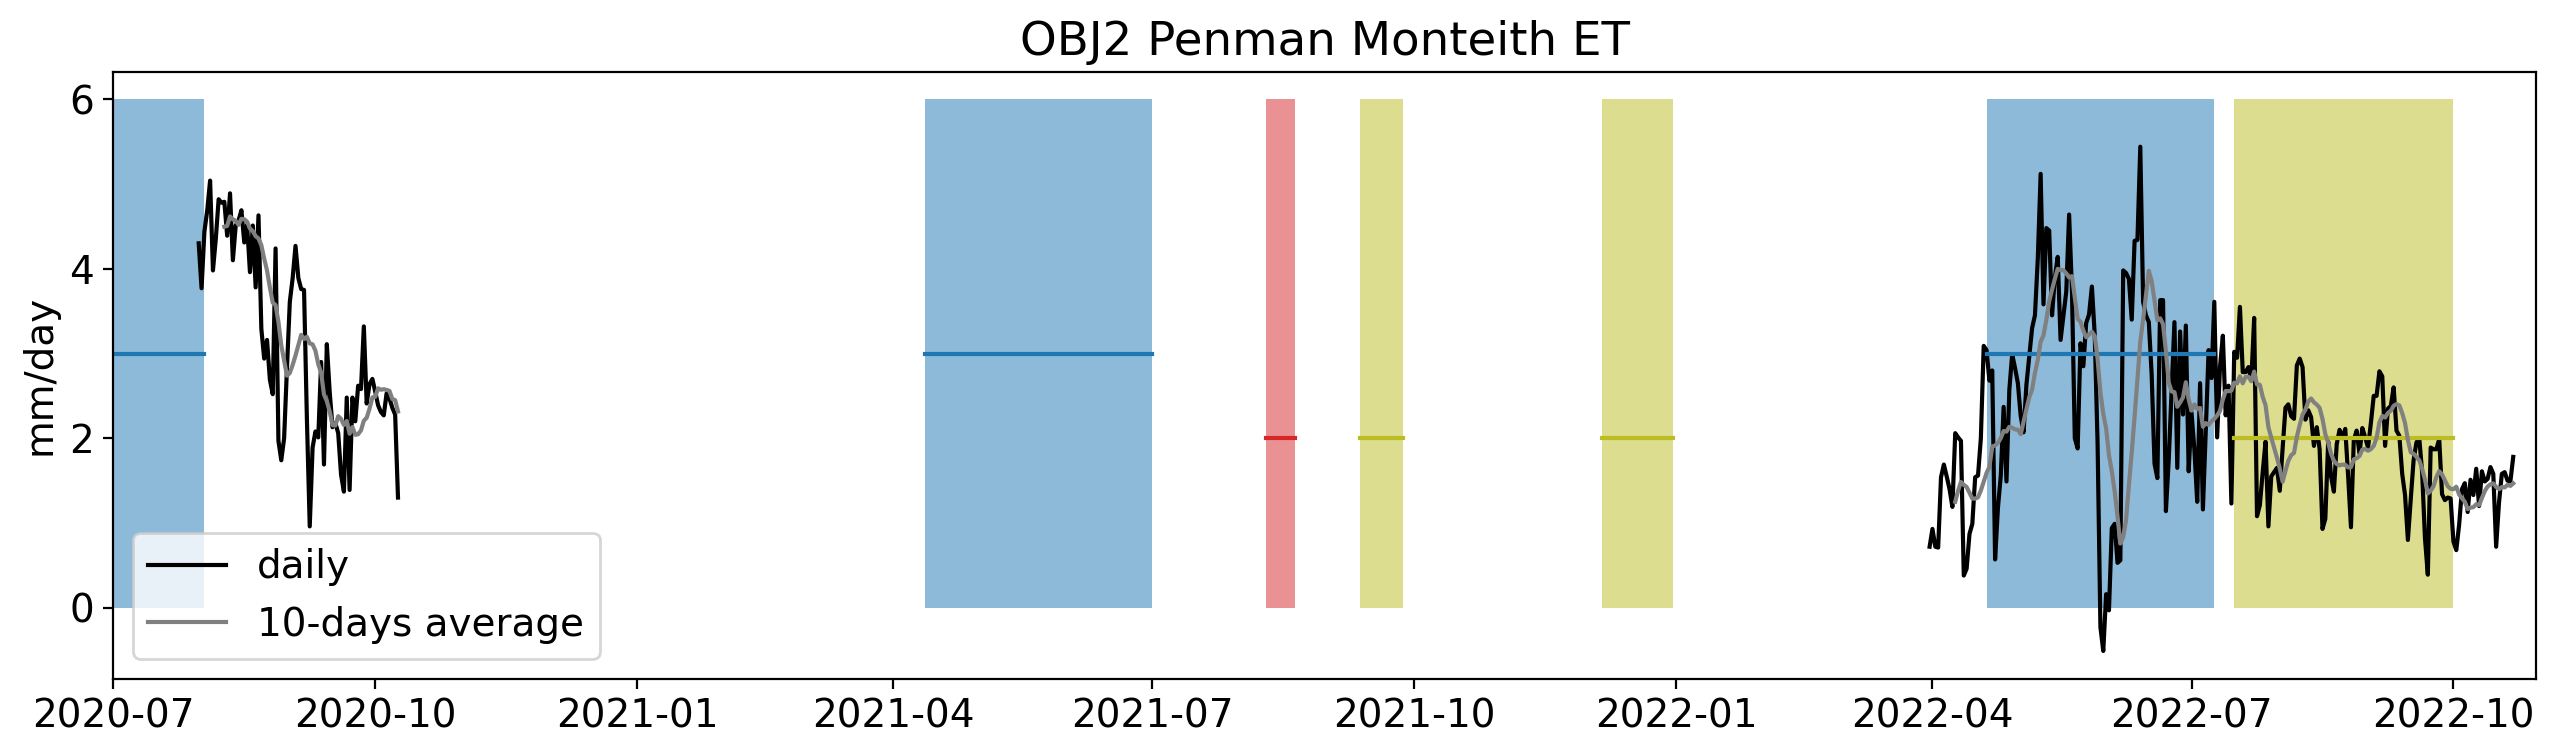

In [13]:
plt.figure(figsize = [13,4],tight_layout=True)
plt.plot(ET['DateTime.MST'],ET['DailyETo.mm.day'],label = 'daily',color = 'black')

month_avg = ET['DailyETo.mm.day'].rolling(window=10).mean()
for interval in time_interval_snowmelt:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [6, 6], alpha=0.5,facecolor='C0')
    plt.plot(interval, [3, 3], c = 'C0')

for interval in time_interval_dry:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [6, 6], alpha=0.5,facecolor='C8')
    plt.plot(interval, [2, 2], c = 'C8')
    
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [6, 6], alpha=0.5,facecolor='C3')
    plt.plot(interval, [2, 2], c = 'C3')

plt.plot(month_avg,label = '10-days average',color = 'grey')

plt.ylabel('mm/day')
plt.xlim(start_date_ET,end_date_ET)
plt.title('OBJ2 Penman Monteith ET')
plt.legend()

# 2. Discharge at Gunsight Bridge

In [14]:
discharge = pd.read_csv('../data/response_data/preprocessing/discharge_WY2021_GSB.csv')
discharge['date'] = pd.to_datetime(discharge['date'])

Text(0.5, 1.0, 'Gunsight Bridge Discharge: daily (m3/s)')

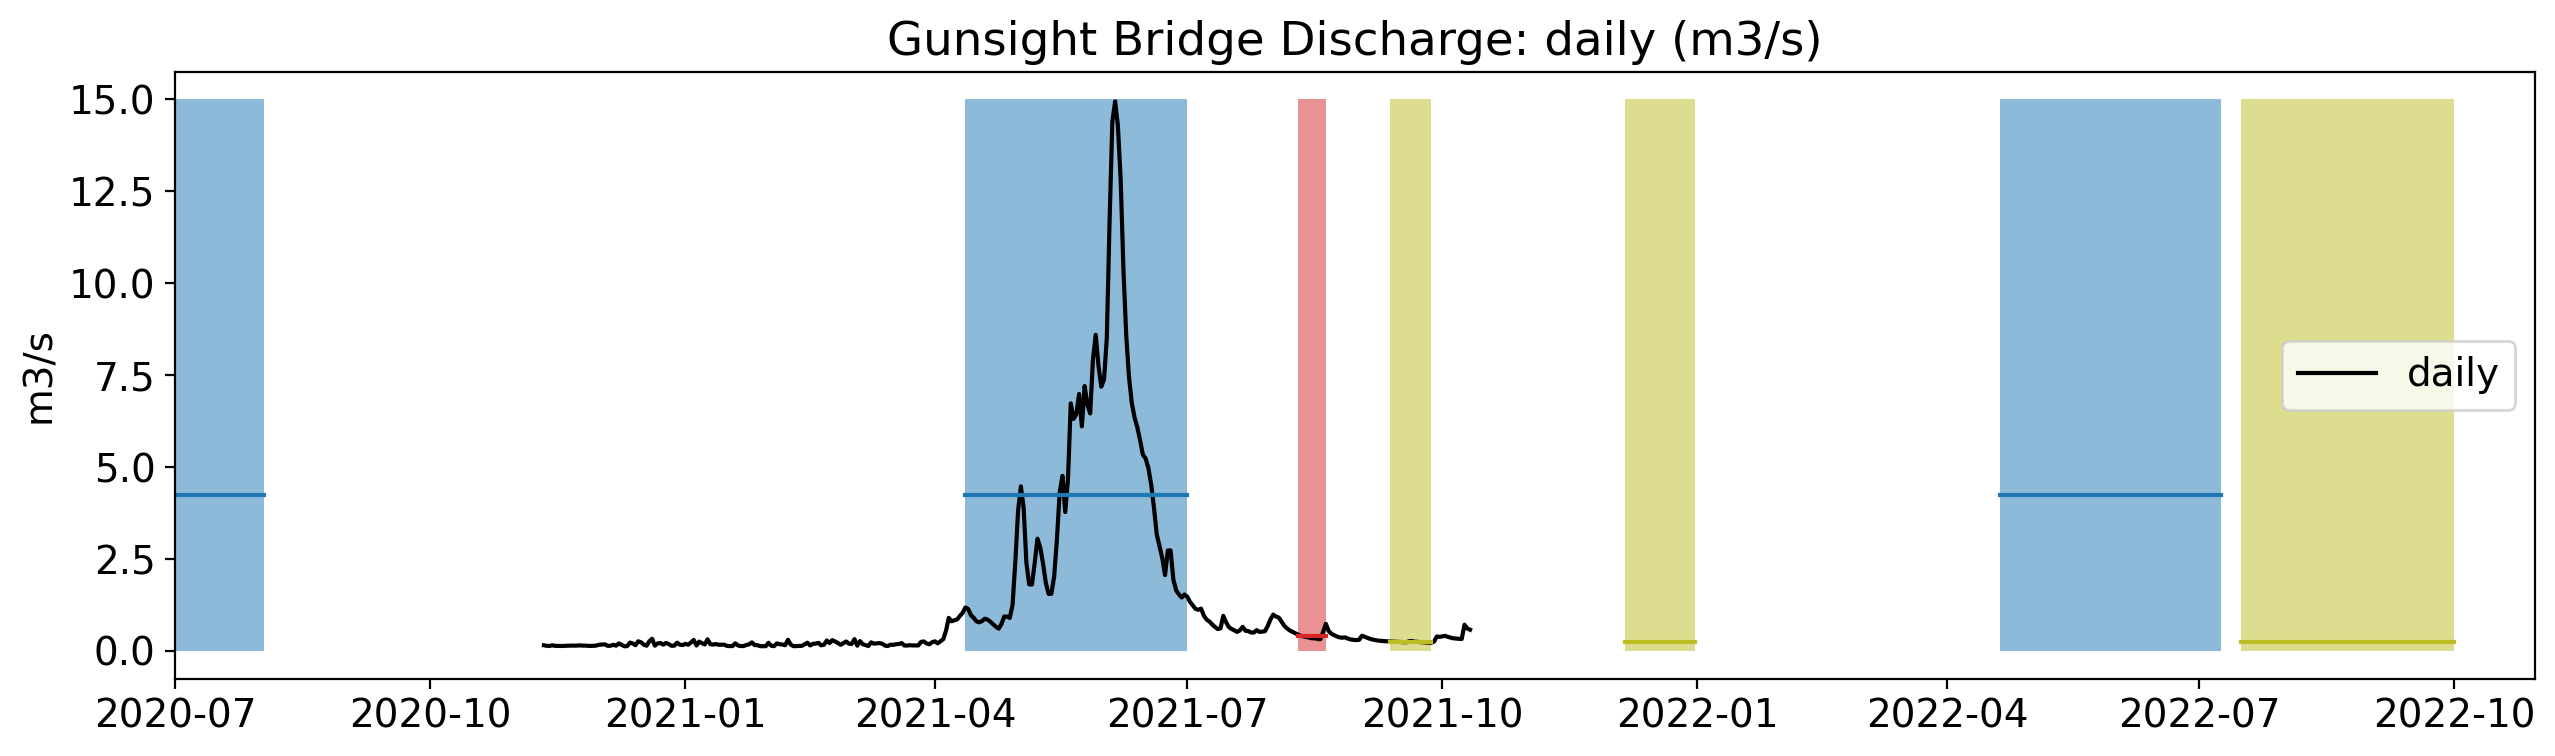

In [15]:
plt.figure(figsize = [13,4],tight_layout=True)
plt.plot(discharge['date'],discharge['Q  (m3/s)'],color = 'black',label = 'daily')
plt.ylabel('m3/s')
for interval in time_interval_snowmelt:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [15, 15], alpha=0.5,facecolor='C0')
    plt.plot(interval, [4.24, 4.24], c = 'C0')

for interval in time_interval_dry:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [15, 15], alpha=0.5,facecolor='C8')
    plt.plot(interval, [0.24, 0.24], c = 'C8')
    
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    plt.fill_between(interval, [0, 0], [15, 15], alpha=0.5,facecolor='C3')
    plt.plot(interval, [0.41, 0.41], c = 'C3')
plt.legend()
plt.xlim(start_date_ET,end_date_ET)
plt.title('Gunsight Bridge Discharge: daily (m3/s)')

# 3. Beaver pond water level

In [17]:
start_date_baseflow =pd.Timestamp('2021-08-10')
end_date_baseflow =pd.Timestamp('2021-09-30')

In [18]:
WL_BD = pd.read_csv('../data/response_data/preprocessing/1_WT_Beaver_Pond_2020_2022.csv') 
# Elevation: 2725.2m
WL_BD['DateTime.MST'] = [datetime.strptime(time,'20%y-%m-%d %H:%M:%S') for time in WL_BD['DateTime.MST']]


In [20]:
start_date_baseflow =  '2021-08-10'
end_date_baseflow = '2021-08-20'
WL_BD[(WL_BD['DateTime.MST'] >= '2021-08-10') & (WL_BD['DateTime.MST'] <= '2021-08-20')]['Pond'].mean()

2725.6994937759337

Text(0.5, 1.0, 'Beaver Pond Water Level Elevation (m)')

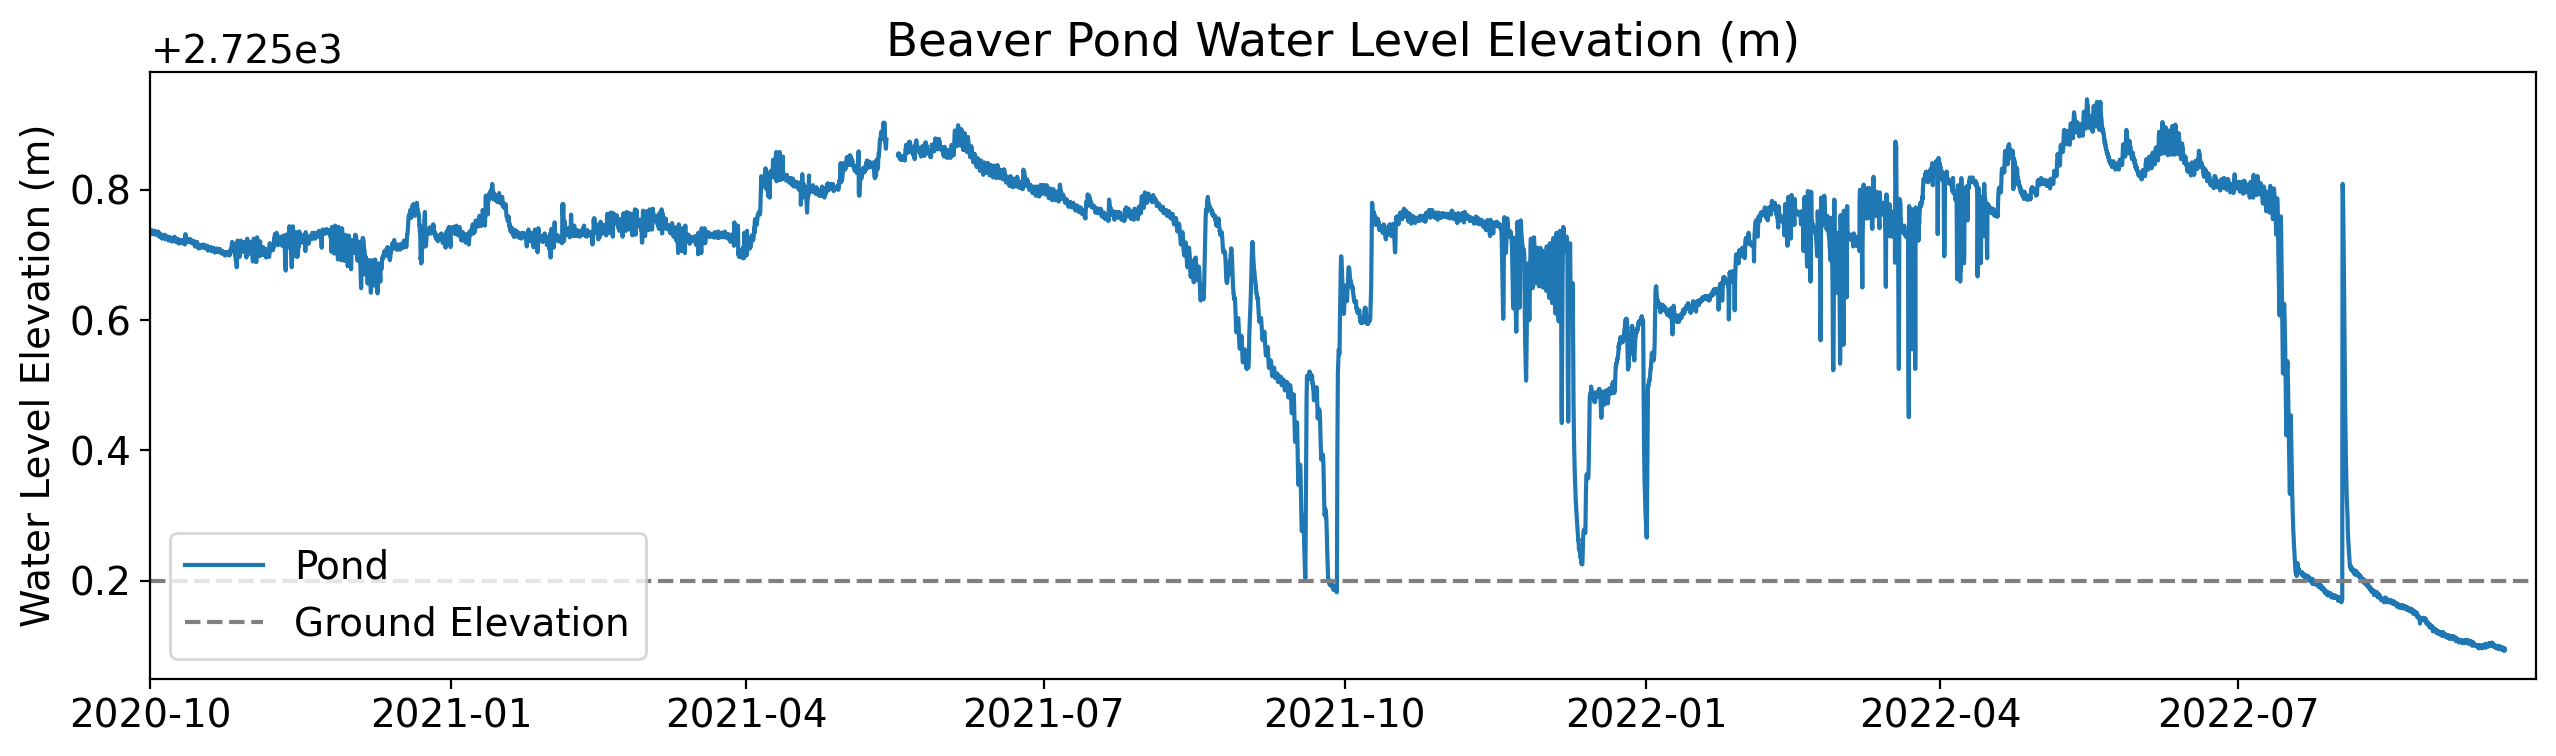

In [21]:
plt.figure(figsize = [13,4],tight_layout=True)
plt.plot(WL_BD['DateTime.MST'],WL_BD['Pond'],label = 'Pond')
plt.xlim(start_date,end_date)
plt.hlines(y = 2725.2, xmin = start_date,xmax = end_date,linestyles='--',color = 'grey',label = 'Ground Elevation')
plt.legend()
plt.ylabel('Water Level Elevation (m)')
plt.title('Beaver Pond Water Level Elevation (m)')

In [23]:
pond = np.load('../data/characterization_data/Beaver_pond_dam/pond_baseflow.npy')

# 4. Gravel bed piezometers

In [22]:
WL_GB = pd.read_csv('../data/response_data/preprocessing/2_WT_Gravel_Bed_2020_2022.csv') 
# Elevation: 2725.2m
WL_GB['DateTime.MST'] = [datetime.strptime(time,'20%y-%m-%d %H:%M:%S') for time in WL_GB['DateTime.MST']]

Text(0.5, 1.0, 'Gravel bed piezometers')

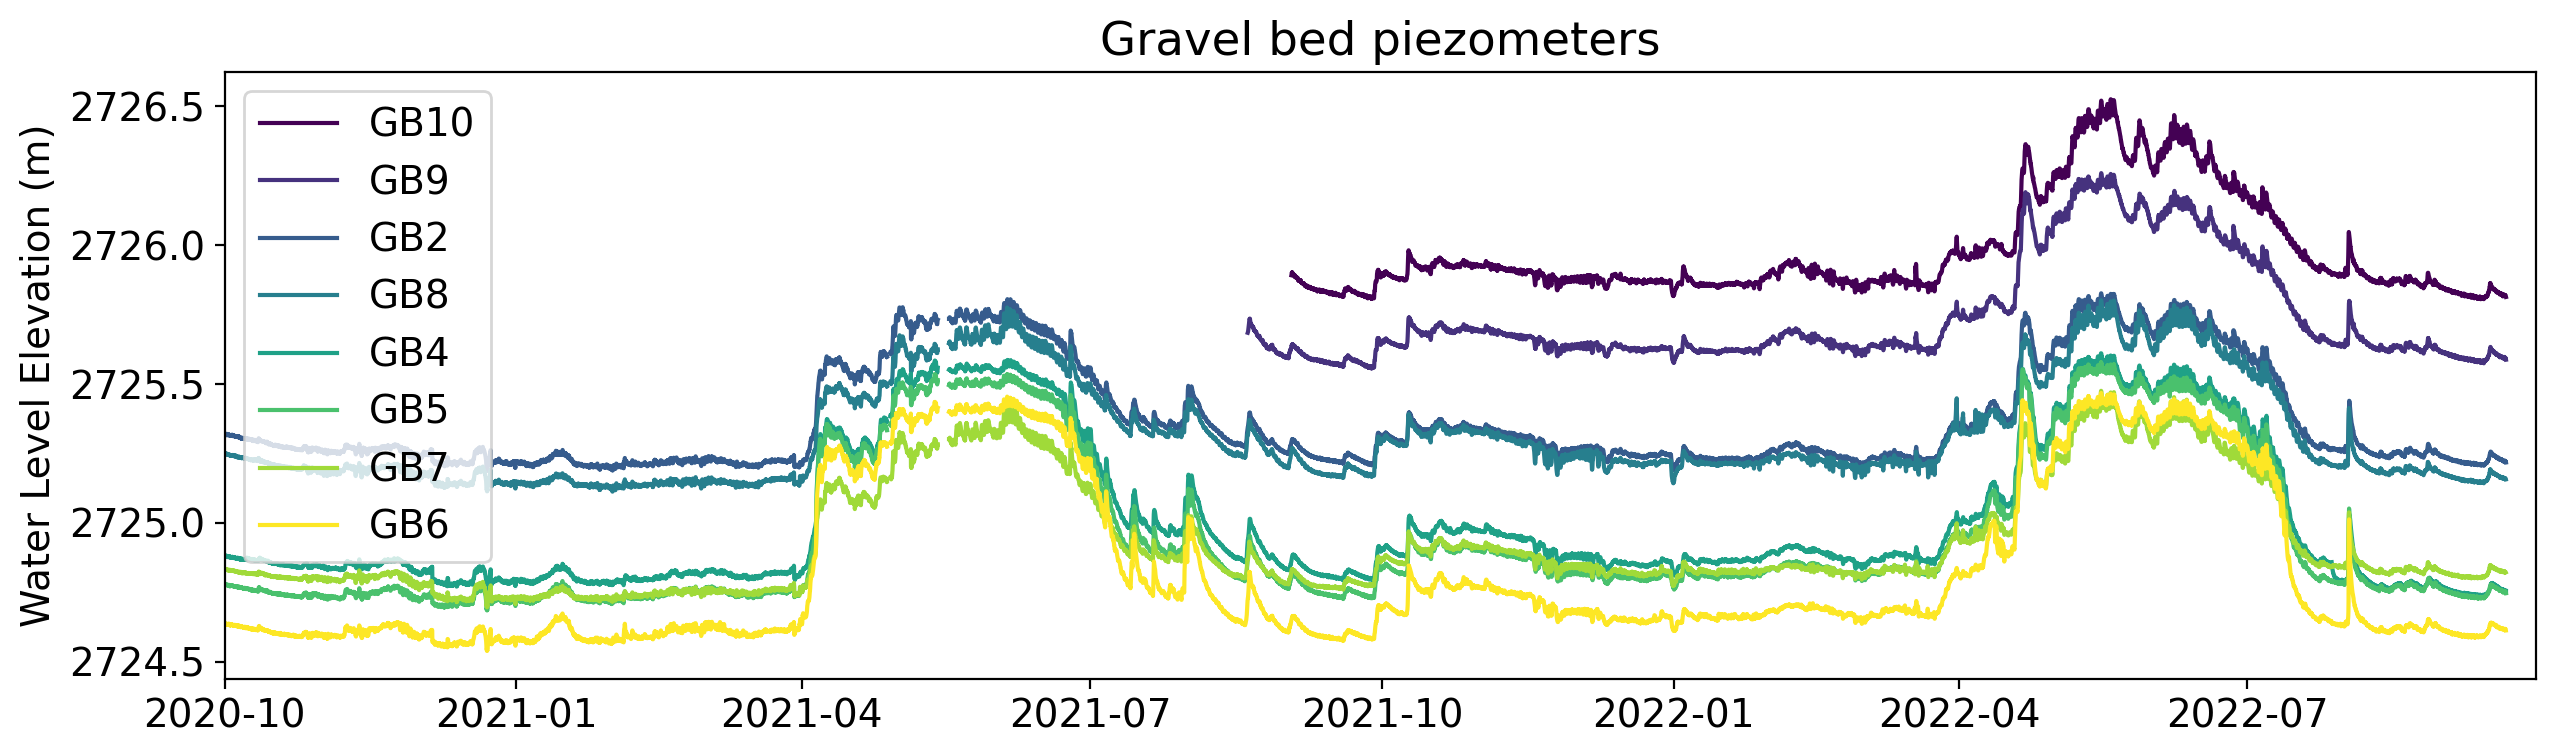

In [23]:
plt.figure(figsize = [13,4],tight_layout=True)
cmap = plt.cm.viridis
#plt.plot(WL_BD['DateTime.MST'],WL_BD['Pond'],label = 'Pond')
#plt.xlim(start_date,end_date)
#plt.hlines(y = 2725.2, xmin = start_date,xmax = end_date,linestyles='--',color = 'grey',label = 'Ground Elevation')

for i,name in enumerate(['GB10','GB9','GB2','GB8','GB4','GB5','GB7','GB6']):
    plt.plot(WL_GB['DateTime.MST'],WL_GB[name],label = name,color = cmap(i/7))
plt.xlim(start_date,end_date)
plt.legend()
plt.ylabel('Water Level Elevation (m)')
plt.title('Gravel bed piezometers')

In [26]:
# plt.figure(figsize = [13,4],tight_layout=True)
# cmap = plt.cm.Greens
# #plt.plot(WL_BD['DateTime.MST'],WL_BD['Pond'],label = 'Pond')
# #plt.xlim(start_date,end_date)
# #plt.hlines(y = 2725.2, xmin = start_date,xmax = end_date,linestyles='--',color = 'grey',label = 'Ground Elevation')

# for i,name in enumerate(['GB9','GB2','GB8','GB4','GB5','GB7','GB6']):#,'GB8','GB4','GB5','GB7','GB6'
#     plt.plot(WL_GB['DateTime.MST'],WL_GB[name],label = name,color = cmap((i+1)/7))
#     plt.hlines(y = locations[locations['ParameterColumnName']==name]['GradeElevation.masl'].values[0]-2, xmin = start_date,xmax = end_date,linestyles='--',color = cmap((i+1)/7))
# plt.xlim(start_date,end_date)
# plt.legend()
# plt.ylabel('Water Level Elevation (m)')
# plt.title('Gravel bed piezometers')

In [27]:
start_date=pd.Timestamp('2020-07-01 00:00:00')
end_date=pd.Timestamp('2022-10-01 00:00:00')

Text(0.5, 1.0, 'Gravel bed piezometers')

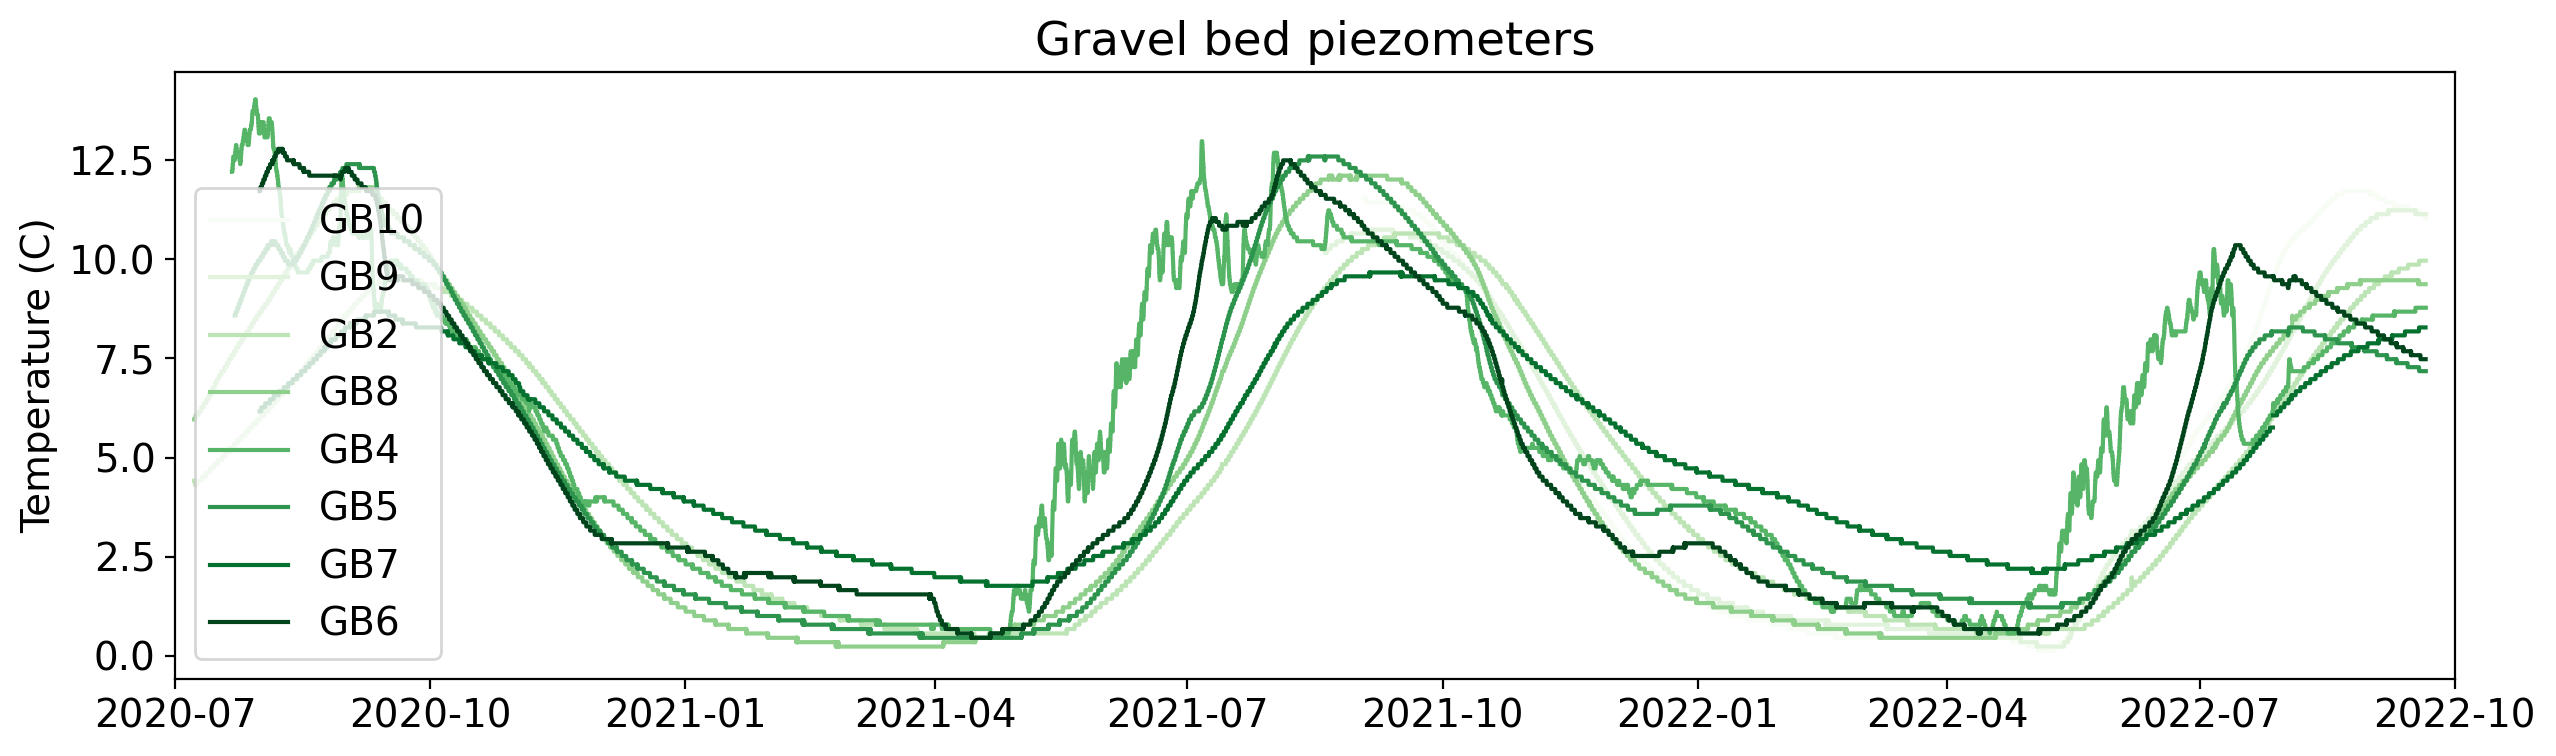

In [28]:
plt.figure(figsize = [13,4],tight_layout=True)
for i,name in enumerate(['GB10','GB9','GB2','GB8','GB4','GB5','GB7','GB6']):
    plt.plot(WL_GB['DateTime.MST'],WL_GB[name+'_T'],label = name,color = cmap(i/7))

plt.xlim(start_date,end_date)
plt.legend()
plt.ylabel('Temperature (C)')
plt.title('Gravel bed piezometers')

# 5. Vertically nested piezometers

In [29]:
# Location
locations = pd.read_csv('../data/response_data/preprocessing/locations_GB_VHG.csv')

In [30]:
WL_VHG = pd.read_csv('../data/response_data/preprocessing/3_WT_VHG_2020_2022.csv') 
WL_VHG['DateTime.MST'] = [datetime.strptime(time,'20%y-%m-%d %H:%M:%S') for time in WL_VHG['DateTime.MST']]

Text(0.5, 1.0, 'Vertically nested piezometers')

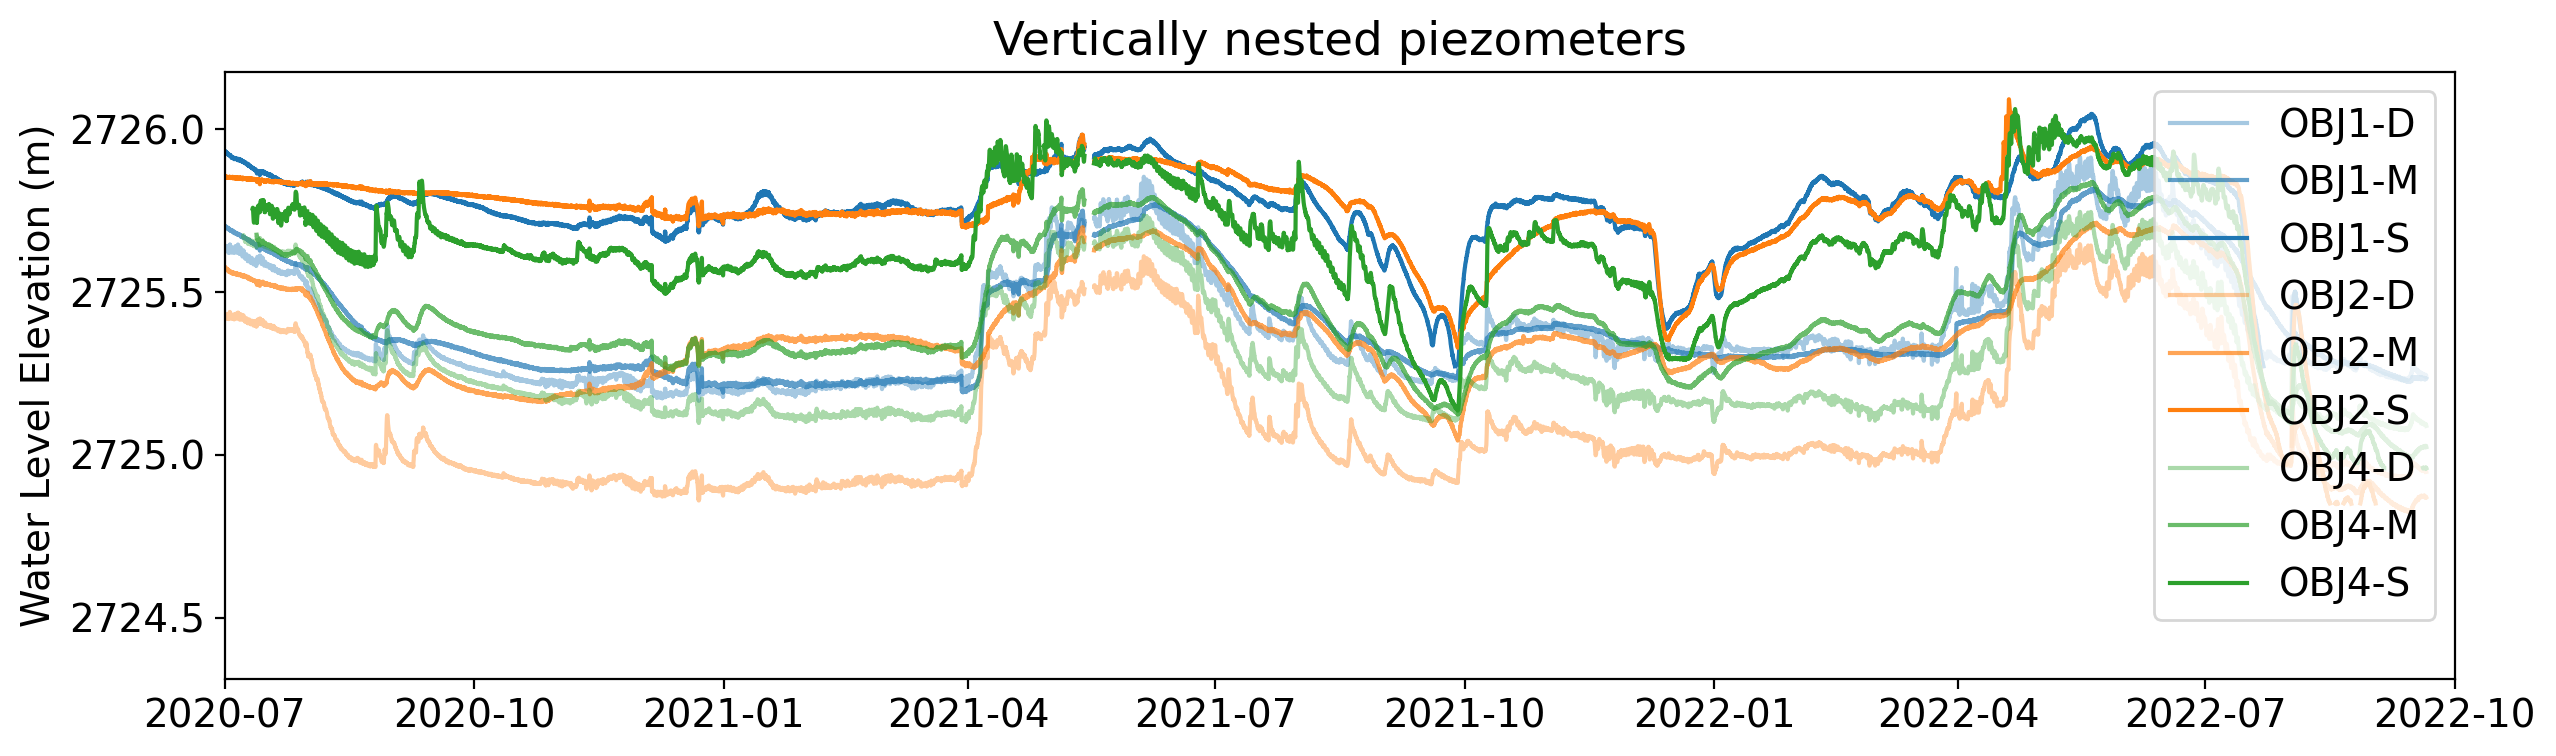

In [31]:
plt.figure(figsize = [13,4],tight_layout=True)
alpha = [0.4,0.7,1]
for i,name in enumerate(['OBJ1-D','OBJ1-M','OBJ1-S']):
    plt.plot(WL_VHG['DateTime.MST'],WL_VHG[name],label = name,c = 'C0',alpha = alpha[i])
for i,name in enumerate(['OBJ2-D','OBJ2-M','OBJ2-S']):
    plt.plot(WL_VHG['DateTime.MST'],WL_VHG[name],label = name,c = 'C1',alpha = alpha[i])
for i,name in enumerate(['OBJ4-D','OBJ4-M','OBJ4-S']):
    plt.plot(WL_VHG['DateTime.MST'],WL_VHG[name],label = name,c = 'C2',alpha = alpha[i])
plt.xlim(start_date,end_date)
#plt.plot(WL_BD['DateTime.MST'],WL_BD['Pond'],label = 'Pond')
plt.legend()
plt.ylabel('Water Level Elevation (m)')
plt.title('Vertically nested piezometers')

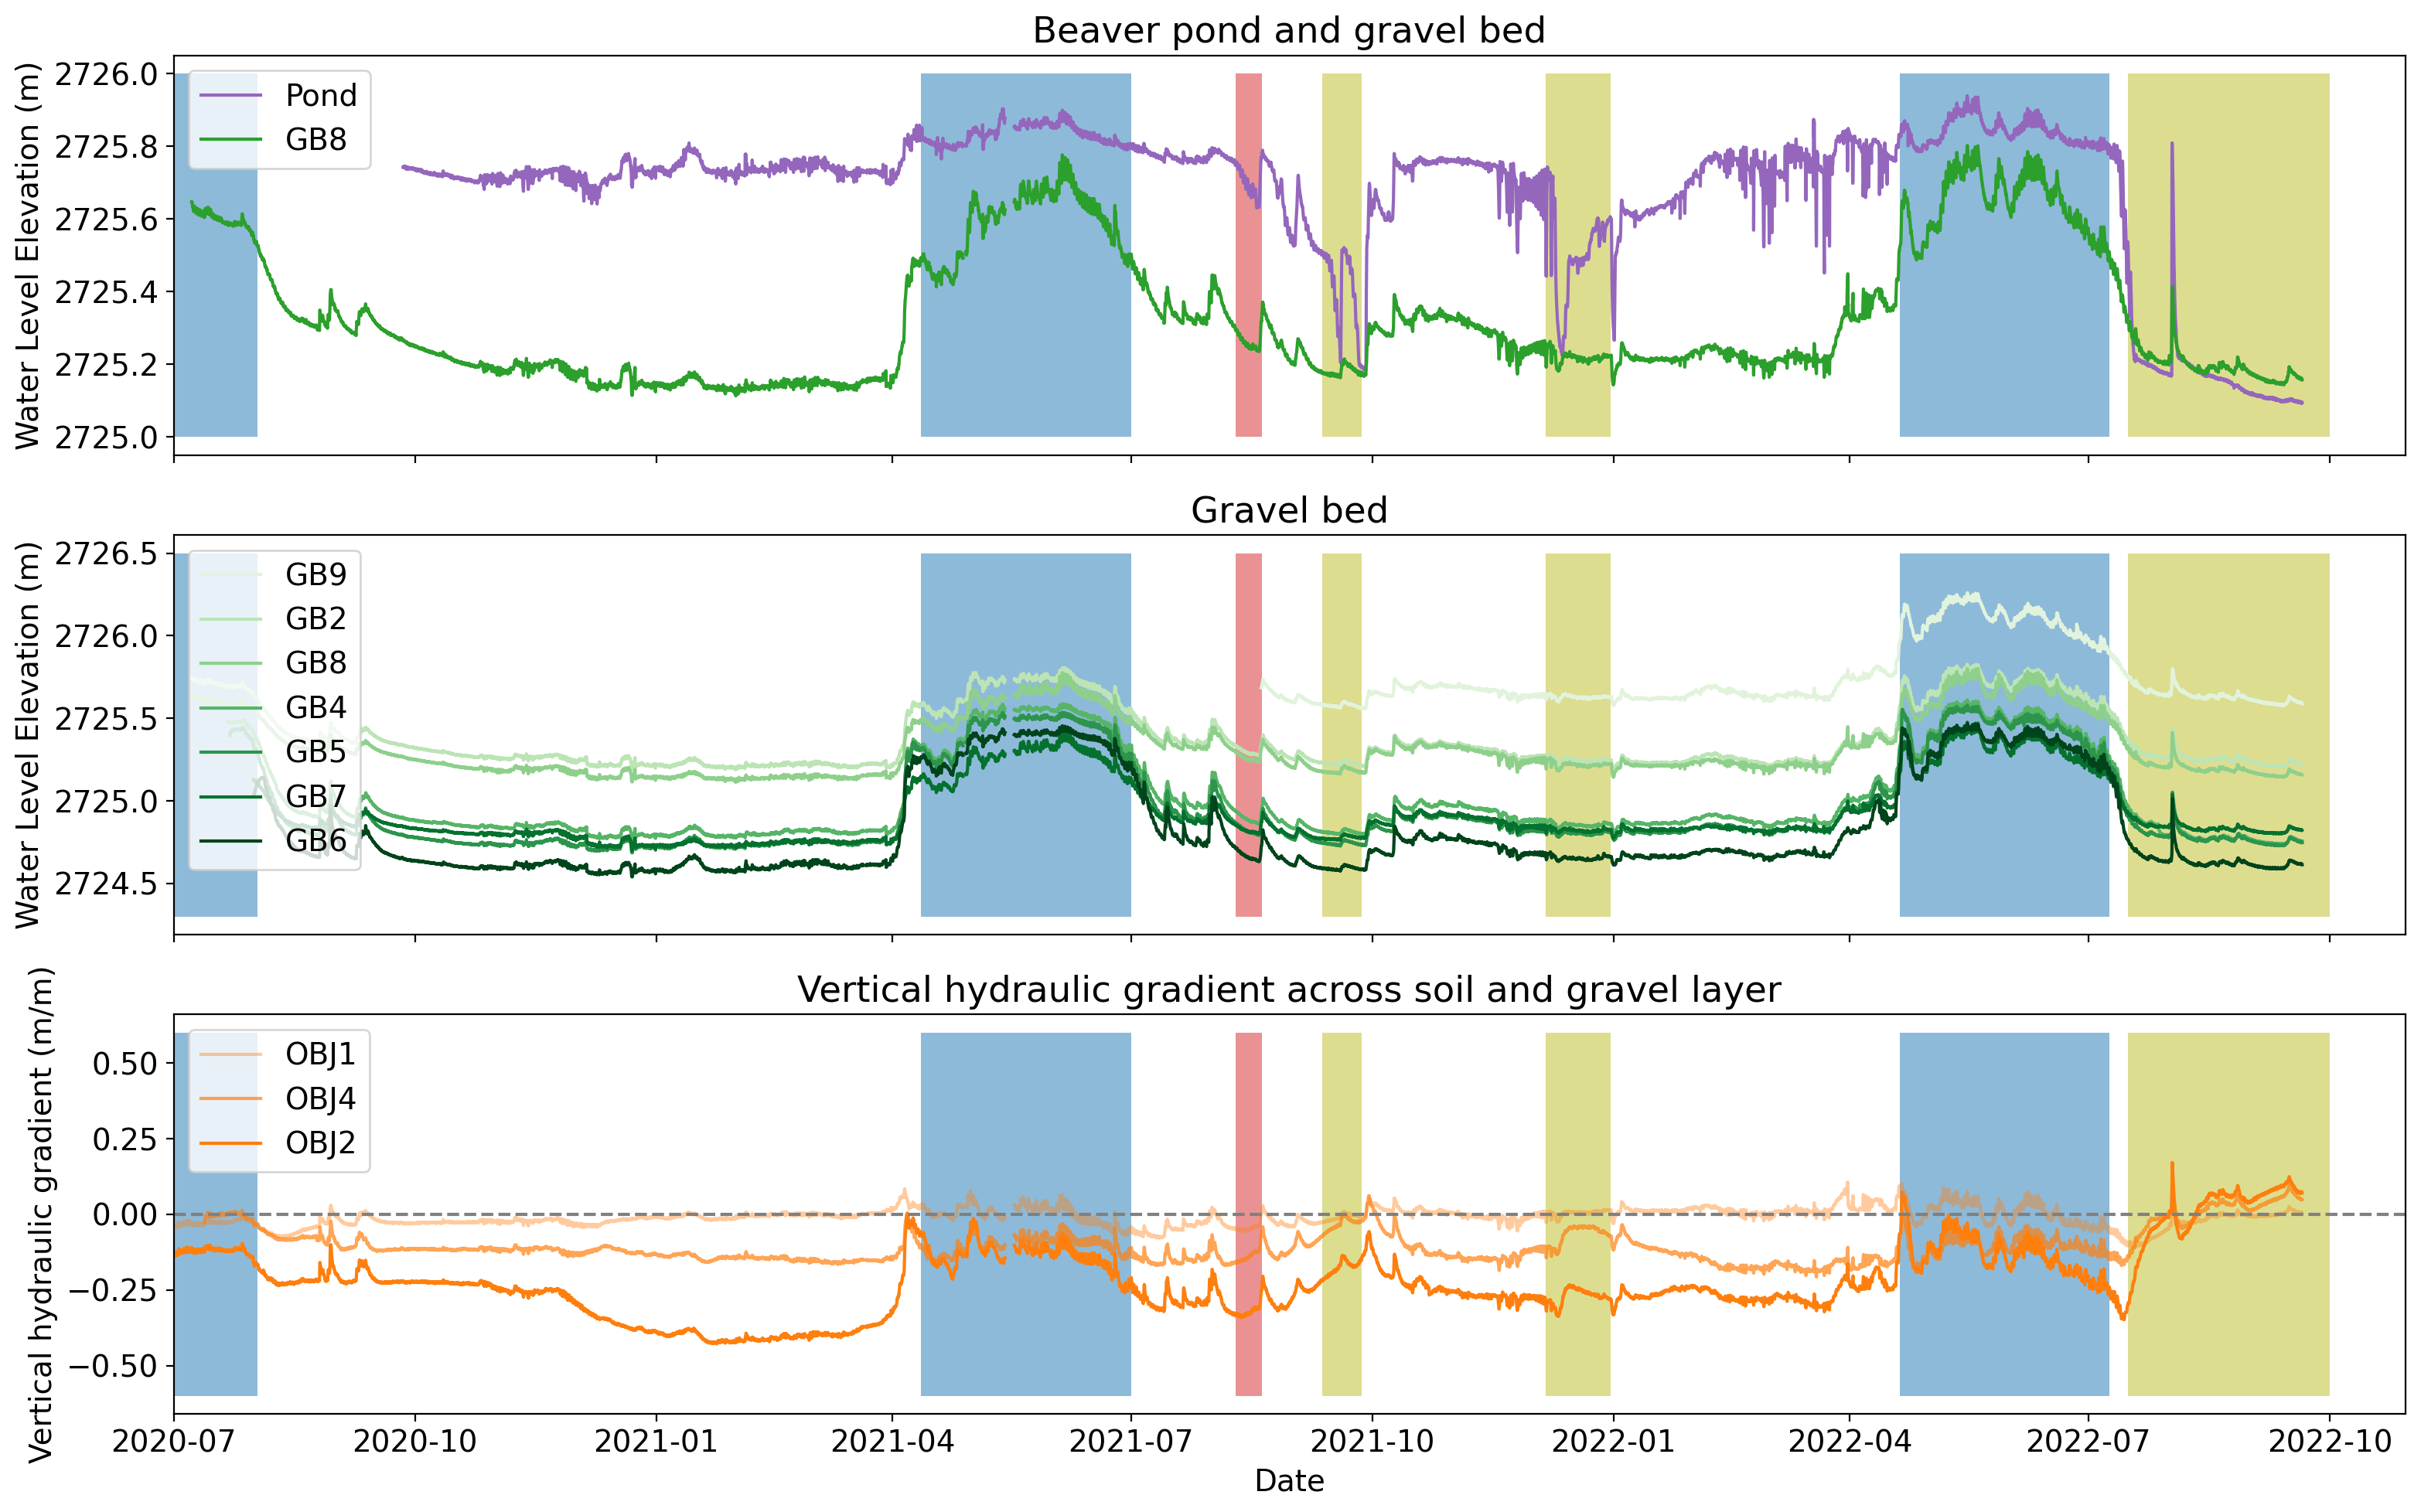

In [34]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np  # Assuming you use numpy for data manipulation


# Define start_date and end_date for plotting range
start_date=pd.Timestamp('2020-07-01 00:00:00')
end_date=pd.Timestamp('2022-10-30 00:00:00')

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True, tight_layout=True)

# First subplot: Beaver pond and gravel bed water level
ax1 = axes[0]
ax1.plot(WL_BD['DateTime.MST'], WL_BD['Pond'], label='Pond', color='C4')
ax1.plot(WL_GB['DateTime.MST'], WL_GB['GB8'], label='GB8', color='C2')
ax1.set_ylabel('Water Level Elevation (m)')
ax1.set_title('Beaver pond and gravel bed')
ax1.legend(loc='upper left')

# Plot snowmelt and dry intervals on the first subplot (ax1)
for interval in time_interval_snowmelt:
    ax1.fill_between(interval, [2725, 2725], [2726, 2726], alpha=0.5, facecolor='C0')
for interval in time_interval_dry:
    ax1.fill_between(interval, [2725, 2725], [2726, 2726], alpha=0.5, facecolor='C8')
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    ax1.fill_between(interval, [2725, 2725], [2726, 2726],  alpha=0.5,facecolor='C3')

# Second subplot: Vertical hydraulic gradient
ax2 = axes[2]
for i, name in enumerate(['OBJ1', 'OBJ4', 'OBJ2']):
    depth_diff = (locations['Depth.m'][locations['ParameterColumnName'] == name + '-D'].values - locations['Depth.m'][locations['ParameterColumnName'] == name + '-M'].values)[0]
    ax2.plot(WL_VHG['DateTime.MST'], (WL_VHG[name + '-D'] - WL_VHG[name + '-M']) / depth_diff, label=name, c='C1', alpha=alpha[i])

ax2.hlines(y=0, xmin=start_date, xmax=end_date, color='grey', linestyles='--')
ax2.set_ylabel('Vertical hydraulic gradient (m/m)')
ax2.set_title('Vertical hydraulic gradient across soil and gravel layer')
ax2.legend(loc='upper left')

for interval in time_interval_snowmelt:
    ax2.fill_between(interval, [-0.6, -0.6], [0.6, 0.6], alpha=0.5, facecolor='C0')
for interval in time_interval_dry:
    ax2.fill_between(interval, [-0.6, -0.6], [0.6, 0.6], alpha=0.5, facecolor='C8')
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    ax2.fill_between(interval, [-0.6, -0.6], [0.6, 0.6],  alpha=0.5,facecolor='C3')

# Third subplot: Gravel bed piezometers
ax3 = axes[1]
colors = plt.cm.Greens(np.linspace(0, 1, 8))  # Creating a color map
for i, name in enumerate(['GB9', 'GB2', 'GB8', 'GB4', 'GB5', 'GB7', 'GB6']):
    #if name == 'GB8':
        #ax3.plot(WL_GB['DateTime.MST'], WL_GB[name], label=name, color='C2')  # Assuming similar structure for WL_GB
    #else:
    ax3.plot(WL_GB['DateTime.MST'], WL_GB[name], label=name, color=colors[i+1])  # Assuming similar structure for WL_GB
ax3.set_ylabel('Water Level Elevation (m)')
ax3.set_title('Gravel bed')
ax3.legend(loc='upper left')

for interval in time_interval_snowmelt:
    ax3.fill_between(interval, [2724.3, 2724.3], [2726.5, 2726.5], alpha=0.5, facecolor='C0')
for interval in time_interval_dry:
    ax3.fill_between(interval, [2724.3, 2724.3], [2726.5, 2726.5], alpha=0.5, facecolor='C8')
for interval in time_interval_baseflow:
    # Use fill_between to fill the area between the start and end of each interval
    ax3.fill_between(interval, [2724.3, 2724.3], [2726.5, 2726.5], alpha=0.5,facecolor='C3')

    
# General settings
plt.xlabel('Date')
#plt.xticks(rotation=45)  # Optional: Rotate date labels for better visibility
plt.xlim(start_date, end_date)

plt.show()


# 6. Snowmelt and dry pond dataset

## Precipitation

In [35]:
print(Met_sum_daily[(Met_sum_daily.index>=start_date_baseflow)&(Met_sum_daily.index<=end_date_baseflow)].mean())

Precip.mm    2.036364
dtype: float64


In [36]:
for interval in time_interval_snowmelt:
    print(Met_sum_daily[(Met_sum_daily.index>=interval[0])&(Met_sum_daily.index<=interval[1])].mean())

Precip.mm    0.0
dtype: float64
Precip.mm    0.545679
dtype: float64
Precip.mm    2.52963
dtype: float64


In [37]:
for interval in time_interval_dry:
    print(Met_sum_daily[(Met_sum_daily.index>=interval[0])&(Met_sum_daily.index<=interval[1])].mean())

Precip.mm    0.53125
dtype: float64
Precip.mm    0.15
dtype: float64
Precip.mm    1.711538
dtype: float64


## ET

In [38]:
print(ET[(ET.index>=start_date_baseflow)&(ET.index<=end_date_baseflow)].mean())

Unnamed: 0         NaN
DateTime.MST       NaT
HourlyETo.mm.hr    NaN
DailyETo.mm.day    NaN
dtype: object


In [39]:
for interval in time_interval_snowmelt:
    print(ET[(ET.index>=interval[0])&(ET.index<=interval[1])].mean())

Unnamed: 0                        24.0
DateTime.MST       2020-08-01 00:00:00
HourlyETo.mm.hr              -0.028333
DailyETo.mm.day                   4.17
dtype: object
Unnamed: 0         NaN
DateTime.MST       NaT
HourlyETo.mm.hr    NaN
DailyETo.mm.day    NaN
dtype: object
Unnamed: 0                      1450.0
DateTime.MST       2022-05-30 00:00:00
HourlyETo.mm.hr              -0.006086
DailyETo.mm.day               2.691358
dtype: object


In [40]:
for interval in time_interval_dry:
    print(ET[(ET.index>=interval[0])&(ET.index<=interval[1])].mean())

Unnamed: 0         NaN
DateTime.MST       NaT
HourlyETo.mm.hr    NaN
DailyETo.mm.day    NaN
dtype: object
Unnamed: 0         NaN
DateTime.MST       NaT
HourlyETo.mm.hr    NaN
DailyETo.mm.day    NaN
dtype: object
Unnamed: 0                      3502.0
DateTime.MST       2022-08-23 12:00:00
HourlyETo.mm.hr              -0.017769
DailyETo.mm.day               1.949487
dtype: object


## Pond

In [41]:
start_date_baseflow =  '2021-08-10'
end_date_baseflow = '2021-08-20'
WL_BD[(WL_BD['DateTime.MST'] >= '2021-08-10') & (WL_BD['DateTime.MST'] <= '2021-08-20')]['Pond'].mean()

2725.6994937759337

In [42]:
for interval in time_interval_snowmelt:
    print(WL_BD[(WL_BD['DateTime.MST'] >= interval[0]) & (WL_BD['DateTime.MST'] <= interval[1])]['Pond'].mean())

nan
2725.8335747380033
2725.8414487246228


## River

In [43]:
baseflow_GB = WL_GB[(WL_GB['DateTime.MST'] >= start_date_baseflow) & (WL_GB['DateTime.MST'] <= end_date_baseflow)].mean()[1:8]

In [44]:
for interval in time_interval_snowmelt:
    print(np.mean(WL_GB[(WL_GB['DateTime.MST'] >= interval[0]) & (WL_GB['DateTime.MST'] <= interval[1])].mean()[1:8]-baseflow_GB))

0.4285325853366733
0.49629084779621735
0.5034635819543577


In [45]:
for interval in time_interval_dry:
    print(np.mean(WL_GB[(WL_GB['DateTime.MST'] >= interval[0]) & (WL_GB['DateTime.MST'] <= interval[1])].mean()[1:8]-baseflow_GB))

-0.07942579167547592
-0.033261636432468676
-0.04542600764086403


## Discharge

In [46]:
discharge[(discharge['date'] >= start_date_baseflow) & (discharge['date'] <= end_date_baseflow)].mean()

Unnamed: 0                  318.0
date          2021-08-15 00:00:00
Q  (m3/s)                0.416395
T (C)                   13.260262
dtype: object

In [47]:
for interval in time_interval_dry:
    print(discharge[(discharge['date'] >= interval[0]) & (discharge['date'] <= interval[1])].mean())
#discharge[(discharge['date'] >= start_date_baseflow) & (discharge['date'] <= end_date_baseflow)].mean()

Unnamed: 0                  353.5
date          2021-09-19 12:00:00
Q  (m3/s)                0.244766
T (C)                    10.67685
dtype: object
Unnamed: 0    NaN
date          NaT
Q  (m3/s)     NaN
T (C)         NaN
dtype: object
Unnamed: 0    NaN
date          NaT
Q  (m3/s)     NaN
T (C)         NaN
dtype: object


In [48]:
for interval in time_interval_snowmelt:
    print(discharge[(discharge['date'] >= interval[0]) & (discharge['date'] <= interval[1])].mean())
#discharge[(discharge['date'] >= start_date_baseflow) & (discharge['date'] <= end_date_baseflow)].mean()

Unnamed: 0    NaN
date          NaT
Q  (m3/s)     NaN
T (C)         NaN
dtype: object
Unnamed: 0                  233.0
date          2021-05-22 00:00:00
Q  (m3/s)                4.246758
T (C)                    5.508299
dtype: object
Unnamed: 0    NaN
date          NaT
Q  (m3/s)     NaN
T (C)         NaN
dtype: object
